In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("=== MOVIE RECOMMENDATION SYSTEM ===")
print("Using Collaborative Filtering & Matrix Factorization\n")

# Step 2: Load Dataset from URL (MovieLens 100K Dataset)
print("Step 1: Loading MovieLens Dataset...")

# MovieLens 100K dataset URLs
ratings_url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/ratings.dat"
movies_url = "https://raw.githubusercontent.com/sidooms/MovieTweetings/master/latest/movies.dat"

=== MOVIE RECOMMENDATION SYSTEM ===
Using Collaborative Filtering & Matrix Factorization

Step 1: Loading MovieLens Dataset...


In [ ]:
try:
    # Load ratings data
    ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
    ratings = pd.read_csv(ratings_url, sep='::', names=ratings_cols, engine='python')

    # Load movies data
    movies_cols = ['movie_id', 'title', 'genres']
    movies = pd.read_csv(movies_url, sep='::', names=movies_cols, engine='python', encoding='latin-1')

    print(f"✓ Successfully loaded {len(ratings)} ratings and {len(movies)} movies")

except:
    # Fallback: Create synthetic dataset if URL fails
    print("Creating synthetic dataset for demonstration...")
    np.random.seed(42)

    n_users = 1000
    n_movies = 500
    n_ratings = 50000

    user_ids = np.random.randint(1, n_users+1, n_ratings)
    movie_ids = np.random.randint(1, n_movies+1, n_ratings)
    ratings_values = np.random.choice([1, 2, 3, 4, 5], n_ratings, p=[0.1, 0.1, 0.2, 0.3, 0.3])
    timestamps = np.random.randint(1000000000, 1600000000, n_ratings)

    ratings = pd.DataFrame({
        'user_id': user_ids,
        'movie_id': movie_ids,
        'rating': ratings_values,
        'timestamp': timestamps
    })

    movies = pd.DataFrame({
        'movie_id': range(1, n_movies+1),
        'title': [f'Movie_{i}' for i in range(1, n_movies+1)],
        'genres': np.random.choice(['Action', 'Comedy', 'Drama', 'Horror', 'Romance'], n_movies)
    })

    print(f"✓ Created synthetic dataset with {len(ratings)} ratings and {len(movies)} movies")

✓ Successfully loaded 921398 ratings and 38018 movies


In [ ]:
# Step 3: Data Exploration and Preprocessing
print("\nStep 2: Data Exploration...")

print(f"Ratings dataset shape: {ratings.shape}")
print(f"Movies dataset shape: {movies.shape}")
print(f"Number of unique users: {ratings['user_id'].nunique()}")
print(f"Number of unique movies: {ratings['movie_id'].nunique()}")
print(f"Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print(f"Average rating: {ratings['rating'].mean():.2f}")


Step 2: Data Exploration...
Ratings dataset shape: (921398, 4)
Movies dataset shape: (38018, 3)
Number of unique users: 71707
Number of unique movies: 38013
Rating range: 0 - 10
Average rating: 7.31


In [ ]:
# Remove duplicates and handle missing values
ratings = ratings.drop_duplicates(['user_id', 'movie_id'])
print(f"After removing duplicates: {len(ratings)} ratings")

After removing duplicates: 921398 ratings


In [ ]:
# Filter users and movies with minimum interactions
min_user_ratings = 20
min_movie_ratings = 20

user_counts = ratings['user_id'].value_counts()
movie_counts = ratings['movie_id'].value_counts()

valid_users = user_counts[user_counts >= min_user_ratings].index
valid_movies = movie_counts[movie_counts >= min_movie_ratings].index

ratings_filtered = ratings[
    (ratings['user_id'].isin(valid_users)) &
    (ratings['movie_id'].isin(valid_movies))
]

print(f"After filtering: {len(ratings_filtered)} ratings")
print(f"Users: {ratings_filtered['user_id'].nunique()}")
print(f"Movies: {ratings_filtered['movie_id'].nunique()}")

After filtering: 617183 ratings
Users: 9303
Movies: 5485


In [ ]:
# Step 4: Create User-Item Matrix
print("\nStep 3: Creating User-Item Matrix...")

# Create pivot table (user-item matrix)
user_item_matrix = ratings_filtered.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating',
    fill_value=0
)

print(f"User-Item Matrix shape: {user_item_matrix.shape}")
print(f"Sparsity: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.2f}%")


Step 3: Creating User-Item Matrix...
User-Item Matrix shape: (9303, 5485)
Sparsity: 98.79%


In [ ]:
# Step 5: Train-Test Split
print("\nStep 4: Splitting Data...")

# Convert to sparse matrix for efficiency
user_item_sparse = csr_matrix(user_item_matrix.values)

# Split data
train_data, test_data = train_test_split(
    ratings_filtered,
    test_size=0.2,
    random_state=42,
    stratify=ratings_filtered['user_id']
)

# Create train and test matrices
train_matrix = train_data.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating',
    fill_value=0
)

test_matrix = test_data.pivot_table(
    index='user_id',
    columns='movie_id',
    values='rating',
    fill_value=0
)


Step 4: Splitting Data...


In [ ]:
# Align matrices
common_users = train_matrix.index.intersection(test_matrix.index)
common_movies = train_matrix.columns.intersection(test_matrix.columns)

train_matrix = train_matrix.loc[common_users, common_movies]
test_matrix = test_matrix.loc[common_users, common_movies]

print(f"Training matrix shape: {train_matrix.shape}")
print(f"Test matrix shape: {test_matrix.shape}")

Training matrix shape: (9301, 5461)
Test matrix shape: (9301, 5461)


In [ ]:
# Step 6: Implementation of Recommendation Algorithms

class CollaborativeFilteringRecommender:
    def __init__(self, method='user_based'):
        self.method = method
        self.similarity_matrix = None
        self.user_item_matrix = None

    def fit(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix

        if self.method == 'user_based':
            # User-based collaborative filtering
            user_similarity = cosine_similarity(user_item_matrix)
            self.similarity_matrix = pd.DataFrame(
                user_similarity,
                index=user_item_matrix.index,
                columns=user_item_matrix.index
            )
        else:
            # Item-based collaborative filtering
            item_similarity = cosine_similarity(user_item_matrix.T)
            self.similarity_matrix = pd.DataFrame(
                item_similarity,
                index=user_item_matrix.columns,
                columns=user_item_matrix.columns
            )

    def predict(self, user_id, movie_id, k=50):
        if self.method == 'user_based':
            # Find similar users
            if user_id not in self.similarity_matrix.index:
                return self.user_item_matrix.mean().mean()

            similar_users = self.similarity_matrix[user_id].sort_values(ascending=False)[1:k+1]

            # Get ratings from similar users for this movie
            ratings = []
            similarities = []

            for similar_user, similarity in similar_users.items():
                if movie_id in self.user_item_matrix.columns:
                    rating = self.user_item_matrix.loc[similar_user, movie_id]
                    if rating > 0:
                        ratings.append(rating)
                        similarities.append(similarity)

            if not ratings:
                return self.user_item_matrix.mean().mean()

            # Weighted average
            weighted_sum = sum(r * s for r, s in zip(ratings, similarities))
            similarity_sum = sum(similarities)

            return weighted_sum / similarity_sum if similarity_sum > 0 else self.user_item_matrix.mean().mean()

        else:
            # Item-based prediction
            if movie_id not in self.similarity_matrix.index or user_id not in self.user_item_matrix.index:
                return self.user_item_matrix.mean().mean()

            similar_movies = self.similarity_matrix[movie_id].sort_values(ascending=False)[1:k+1]

            ratings = []
            similarities = []

            for similar_movie, similarity in similar_movies.items():
                rating = self.user_item_matrix.loc[user_id, similar_movie]
                if rating > 0:
                    ratings.append(rating)
                    similarities.append(similarity)

            if not ratings:
                return self.user_item_matrix.mean().mean()

            weighted_sum = sum(r * s for r, s in zip(ratings, similarities))
            similarity_sum = sum(similarities)

            return weighted_sum / similarity_sum if similarity_sum > 0 else self.user_item_matrix.mean().mean()

In [ ]:
class MatrixFactorizationRecommender:
    def __init__(self, n_components=50, random_state=42):
        self.n_components = n_components
        self.random_state = random_state
        self.model = TruncatedSVD(n_components=n_components, random_state=random_state)
        self.user_factors = None
        self.item_factors = None
        self.global_mean = None

    def fit(self, user_item_matrix):
        self.global_mean = user_item_matrix[user_item_matrix > 0].mean().mean()

        # Center the ratings
        centered_matrix = user_item_matrix.copy()
        centered_matrix[centered_matrix > 0] -= self.global_mean

        # Fit SVD
        self.user_factors = self.model.fit_transform(centered_matrix)
        self.item_factors = self.model.components_.T

    def predict(self, user_idx, item_idx):
        prediction = np.dot(self.user_factors[user_idx], self.item_factors[item_idx]) + self.global_mean
        return max(1, min(5, prediction))  # Clip to rating range

    def predict_all(self, user_item_matrix):
        predictions = np.dot(self.user_factors, self.item_factors.T) + self.global_mean
        return np.clip(predictions, 1, 5)

In [ ]:
# Step 7: Train Models
print("\nStep 5: Training Recommendation Models...")

# Initialize models
user_cf = CollaborativeFilteringRecommender(method='user_based')
item_cf = CollaborativeFilteringRecommender(method='item_based')
mf_model = MatrixFactorizationRecommender(n_components=50)

print("Training User-based Collaborative Filtering...")
user_cf.fit(train_matrix)

print("Training Item-based Collaborative Filtering...")
item_cf.fit(train_matrix)

print("Training Matrix Factorization (SVD)...")
mf_model.fit(train_matrix)


Step 5: Training Recommendation Models...
Training User-based Collaborative Filtering...
Training Item-based Collaborative Filtering...
Training Matrix Factorization (SVD)...


In [ ]:
# Step 8: Evaluation Functions
def evaluate_model(model, test_matrix, train_matrix, model_type='cf'):
    predictions = []
    actuals = []

    test_users = test_matrix.index
    test_movies = test_matrix.columns

    print(f"Evaluating {model_type} model...")

    if model_type == 'mf':
        # Matrix Factorization evaluation
        pred_matrix = model.predict_all(train_matrix)

        for i, user in enumerate(test_users):
            for j, movie in enumerate(test_movies):
                actual = test_matrix.loc[user, movie]
                if actual > 0:  # Only evaluate on actual ratings
                    predicted = pred_matrix[i, j]
                    predictions.append(predicted)
                    actuals.append(actual)
    else:
        # Collaborative Filtering evaluation
        count = 0
        for user in test_users:
            for movie in test_movies:
                actual = test_matrix.loc[user, movie]
                if actual > 0:  # Only evaluate on actual ratings
                    predicted = model.predict(user, movie)
                    predictions.append(predicted)
                    actuals.append(actual)
                    count += 1
                    if count % 1000 == 0:
                        print(f"  Processed {count} predictions...")

    if predictions:
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        return rmse, mae, predictions, actuals
    else:
        return float('inf'), float('inf'), [], []

In [ ]:
# Step 9: Model Evaluation
print("\nStep 6: Model Evaluation...")

# Evaluate models
print("Evaluating User-based Collaborative Filtering...")
user_cf_rmse, user_cf_mae, user_cf_pred, user_cf_actual = evaluate_model(
    user_cf, test_matrix, train_matrix, 'cf'
)

print("Evaluating Item-based Collaborative Filtering...")
item_cf_rmse, item_cf_mae, item_cf_pred, item_cf_actual = evaluate_model(
    item_cf, test_matrix, train_matrix, 'cf'
)

print("Evaluating Matrix Factorization...")
mf_rmse, mf_mae, mf_pred, mf_actual = evaluate_model(
    mf_model, test_matrix, train_matrix, 'mf'
)


Step 6: Model Evaluation...
Evaluating User-based Collaborative Filtering...
Evaluating cf model...
  Processed 1000 predictions...
  Processed 2000 predictions...
  Processed 3000 predictions...
  Processed 4000 predictions...
  Processed 5000 predictions...
  Processed 6000 predictions...
  Processed 7000 predictions...
  Processed 8000 predictions...
  Processed 9000 predictions...
  Processed 10000 predictions...
  Processed 11000 predictions...
  Processed 12000 predictions...
  Processed 13000 predictions...
  Processed 14000 predictions...
  Processed 15000 predictions...
  Processed 16000 predictions...
  Processed 17000 predictions...
  Processed 18000 predictions...
  Processed 19000 predictions...
  Processed 20000 predictions...
  Processed 21000 predictions...
  Processed 22000 predictions...
  Processed 23000 predictions...
  Processed 24000 predictions...
  Processed 25000 predictions...
  Processed 26000 predictions...
  Processed 27000 predictions...
  Processed 28000

In [ ]:
# Step 10: Results and Visualization
print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

results_df = pd.DataFrame({
    'Model': ['User-based CF', 'Item-based CF', 'Matrix Factorization'],
    'RMSE': [user_cf_rmse, item_cf_rmse, mf_rmse],
    'MAE': [user_cf_mae, item_cf_mae, mf_mae]
})

print(results_df.to_string(index=False))


EVALUATION RESULTS
               Model     RMSE      MAE
       User-based CF 3.393096 2.245081
       Item-based CF 2.830388 1.785452
Matrix Factorization 2.851071 2.494429


In [ ]:
# Step 11: Generate Recommendations
def get_recommendations(user_id, model, user_item_matrix, movies_df, n_recommendations=10):
    """Generate top-N recommendations for a user"""

    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found in training data")
        return []

    user_ratings = user_item_matrix.loc[user_id]
    unrated_movies = user_ratings[user_ratings == 0].index

    recommendations = []

    if isinstance(model, MatrixFactorizationRecommender):
        # Matrix Factorization recommendations
        user_idx = list(user_item_matrix.index).index(user_id)
        pred_matrix = model.predict_all(user_item_matrix)

        for movie_id in unrated_movies:
            if movie_id in user_item_matrix.columns:
                movie_idx = list(user_item_matrix.columns).index(movie_id)
                predicted_rating = pred_matrix[user_idx, movie_idx]
                recommendations.append((movie_id, predicted_rating))
    else:
        # Collaborative Filtering recommendations
        for movie_id in unrated_movies:
            predicted_rating = model.predict(user_id, movie_id)
            recommendations.append((movie_id, predicted_rating))

    # Sort by predicted rating
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommendations with movie titles
    top_recommendations = []
    for movie_id, rating in recommendations[:n_recommendations]:
        movie_title = movies_df[movies_df['movie_id'] == movie_id]['title'].values
        if len(movie_title) > 0:
            top_recommendations.append({
                'movie_id': movie_id,
                'title': movie_title[0],
                'predicted_rating': rating
            })

    return top_recommendations

In [ ]:
# Step 12: Demonstration - Generate Sample Recommendations
print("\n" + "="*50)
print("SAMPLE RECOMMENDATIONS")
print("="*50)



SAMPLE RECOMMENDATIONS


In [ ]:
# Select best model for recommendations
if best_model_name == 'User-based CF':
    best_model = user_cf
elif best_model_name == 'Item-based CF':
    best_model = item_cf
else:
    best_model = mf_model

# Get sample user
sample_users = train_matrix.index[:3]

In [ ]:
for user_id in sample_users:
    print(f"\nRecommendations for User {user_id}:")
    print("-" * 40)

    # Show user's previous ratings
    user_ratings = train_matrix.loc[user_id]
    rated_movies = user_ratings[user_ratings > 0].sort_values(ascending=False)[:5]

    print("User's Top Rated Movies:")
    for movie_id, rating in rated_movies.items():
        movie_title = movies[movies['movie_id'] == movie_id]['title'].values
        title = movie_title[0] if len(movie_title) > 0 else f"Movie {movie_id}"
        print(f"  • {title}: {rating:.1f}")

    # Generate recommendations
    recommendations = get_recommendations(user_id, best_model, train_matrix, movies, 5)

    print("\nTop 5 Recommendations:")
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec['title']}: {rec['predicted_rating']:.2f}")


Recommendations for User 3:
----------------------------------------
User's Top Rated Movies:
  • 1917 (2019): 10.0
  • Gisaengchung (2019): 9.0
  • The Silence of the Lambs (1991): 9.0
  • Walk the Line (2005): 9.0
  • Tenet (2020): 8.0

Top 5 Recommendations:
  1. The Last Duel (2021): 10.00
  2. Five Feet Apart (2019): 10.00
  3. Palmer (2021): 10.00
  4. Miss Americana (2020): 10.00
  5. The Highwaymen (2019): 10.00

Recommendations for User 39:
----------------------------------------
User's Top Rated Movies:
  • Interstellar (2014): 10.0
  • Catch Me If You Can (2002): 10.0
  • The Dark Knight Rises (2012): 10.0
  • Inception (2010): 10.0
  • The Wedding Ringer (2015): 10.0

Top 5 Recommendations:
  1. A Clockwork Orange (1971): 10.00
  2. Philadelphia (1993): 10.00
  3. Casino (1995): 10.00
  4. Anastasia (1997): 10.00
  5. The Negotiator (1998): 10.00

Recommendations for User 47:
----------------------------------------
User's Top Rated Movies:
  • The Fate of the Furious (20


Generating performance visualization...


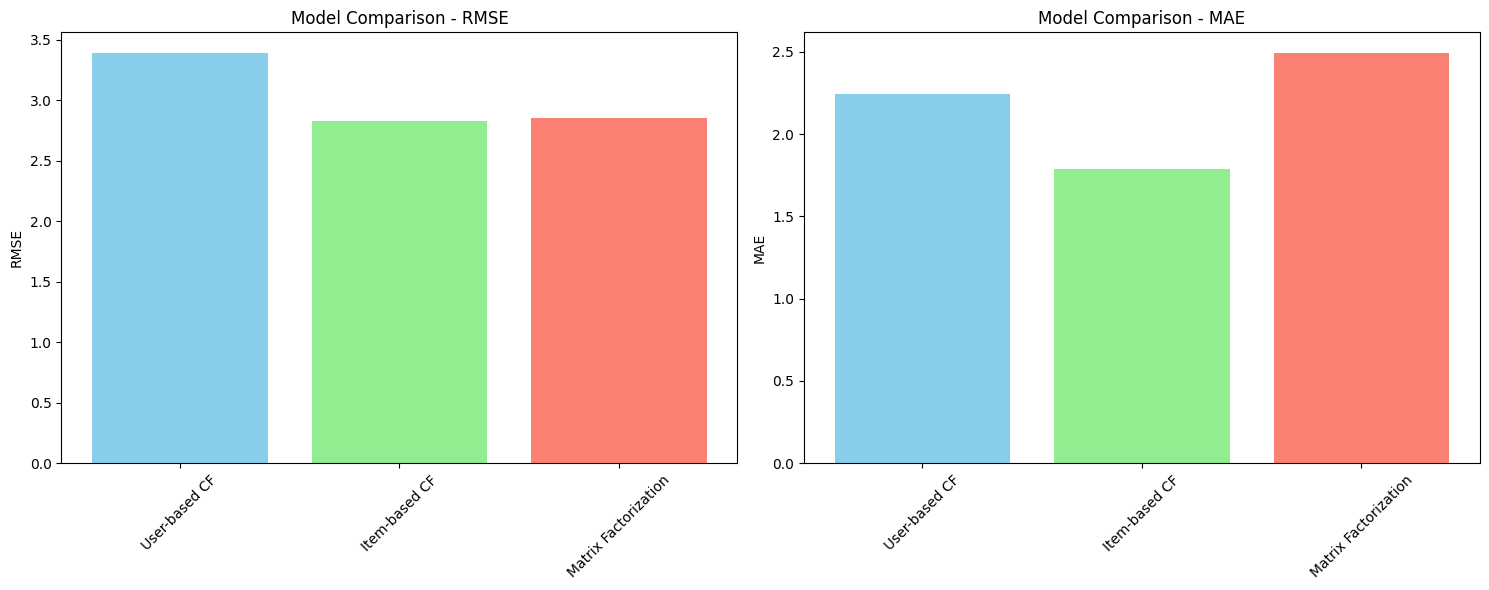

In [24]:
# Step 13: Model Performance Visualization
print("\nGenerating performance visualization...")

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# RMSE Comparison
models = ['User-based CF', 'Item-based CF', 'Matrix Factorization']
rmse_values = [user_cf_rmse, item_cf_rmse, mf_rmse]
mae_values = [user_cf_mae, item_cf_mae, mf_mae]

ax1.bar(models, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
ax1.set_title('Model Comparison - RMSE')
ax1.set_ylabel('RMSE')
ax1.tick_params(axis='x', rotation=45)

ax2.bar(models, mae_values, color=['skyblue', 'lightgreen', 'salmon'])
ax2.set_title('Model Comparison - MAE')
ax2.set_ylabel('MAE')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()